In [67]:
# --- Import libraries ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# --- Load the dataset ---
df = pd.read_excel("A:/Processed_Flipdata.xlsx")

# --- 1. Check for missing values ---
print("Missing values before cleaning:\n", df.isnull().sum())

# no Missing values

# --- 2. Handle outliers using IQR method ---
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap outliers
    df[col] = np.where(df[col] < lower_bound, lower_bound,
                       np.where(df[col] > upper_bound, upper_bound, df[col]))

# --- 3. One-Hot Encode categorical variables ---
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' avoids multicollinearity
encoded_data = pd.DataFrame(encoder.fit_transform(df[cat_cols]), columns=encoder.get_feature_names_out(cat_cols))

# Combine encoded columns with numeric columns
df_encoded = pd.concat([df[num_cols].reset_index(drop=True), encoded_data.reset_index(drop=True)], axis=1)

# --- 4. Save cleaned data ---
df_encoded.to_excel("Cleaned_Flipdata.xlsx", index=False)
print("\n Cleaned and encoded dataset saved as 'Cleaned_Flipdata.xlsx'")
df.select_dtypes(include=['int64', 'float64']).head()
df = df.drop(df.columns[[0, 8]], axis=1)# As these columns is not contributing in the Predictions
df.head()

Missing values before cleaning:
 Unnamed: 0       0
Model            0
Colour           0
Memory           0
RAM              0
Battery_         0
Rear Camera      0
Front Camera     0
AI Lens          0
Mobile Height    0
Processor_       0
Prize            0
dtype: int64

 Cleaned and encoded dataset saved as 'Cleaned_Flipdata.xlsx'


,Model,Colour,Memory,RAM,Battery_,Rear Camera,Front Camera,Mobile Height,Processor_,Prize
0,Infinix SMART 7,Night Black,64.0,4.0,5000.0,13MP,5MP,16.76,Unisoc Spreadtrum SC9863A1,7299.0
1,Infinix SMART 7,Azure Blue,64.0,4.0,5000.0,13MP,5MP,16.76,Unisoc Spreadtrum SC9863A1,7299.0
2,MOTOROLA G32,Mineral Gray,128.0,8.0,5000.0,50MP,16MP,16.64,Qualcomm Snapdragon 680,11999.0
3,POCO C50,Royal Blue,32.0,2.0,5000.0,8MP,5MP,16.56,Mediatek Helio A22,5649.0
4,Infinix HOT 30i,Marigold,128.0,8.0,5000.0,50MP,5MP,16.76,G37,8999.0


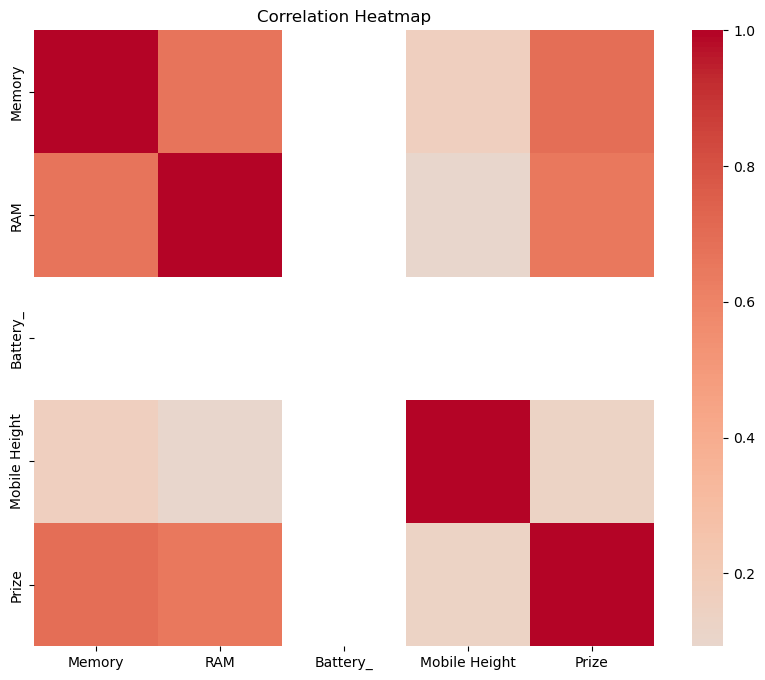


Top features correlated with price:
 Prize            1.000000
Memory           0.692721
RAM              0.651490
Mobile Height    0.132029
Battery_              NaN
Name: Prize, dtype: float64

Top 15 important features (Random Forest):
 Memory                                  0.455254
RAM                                     0.108051
Mobile Height                           0.056110
Front Camera_32MP                       0.033652
Rear Camera_12MP                        0.031708
Processor__SC6531E                      0.026532
Front Camera_5MP                        0.024127
Front Camera_16MP                       0.016777
Front Camera_12MP                       0.015578
Rear Camera_50MP                        0.008934
Processor__ios                          0.008811
Front Camera_8MP                        0.008455
Front Camera_50MP                       0.008413
Front Camera_13MP                       0.007117
Processor__Qualcomm Snapdragon 778G+    0.006786
dtype: float64


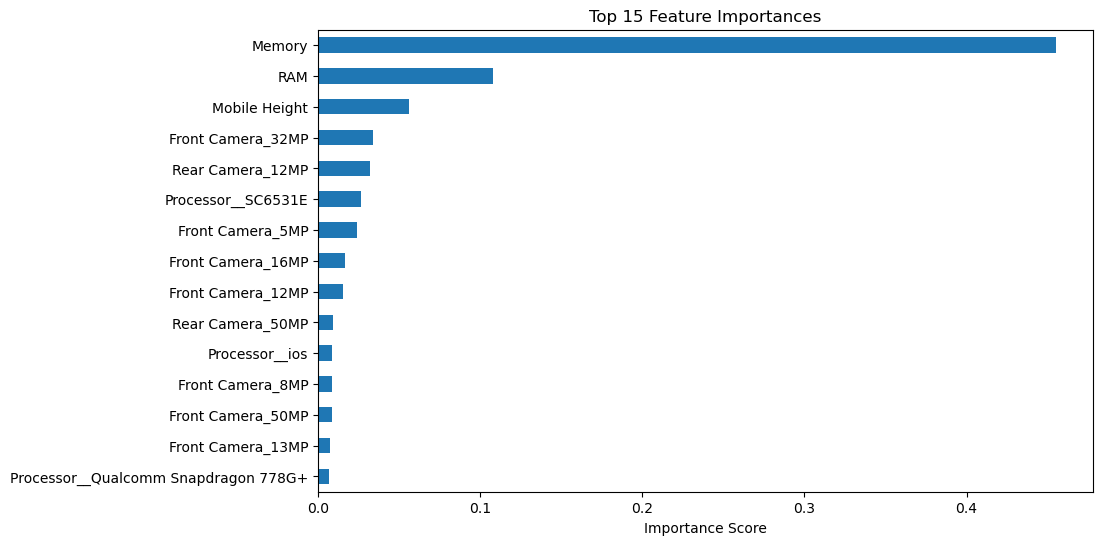


Top 10 features selected using ANOVA F-test:
 ['Memory', 'RAM', 'Rear Camera_12MP', 'Rear Camera_13MP', 'Rear Camera_200MP', 'Rear Camera_64MP', 'Rear Camera_8MP', 'Front Camera_16MP', 'Front Camera_32MP', 'Front Camera_5MP']


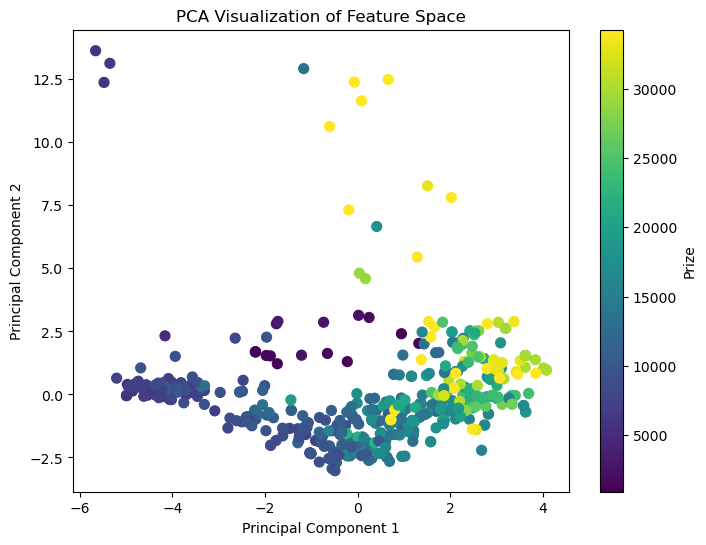


 Final Recommended Key Features Influencing Price:
 ['Rear Camera_64MP', 'Rear Camera_8MP', 'Rear Camera_12MP', 'Front Camera_16MP', 'Rear Camera_13MP', 'Rear Camera_50MP', 'Front Camera_12MP', 'Rear Camera_200MP', 'Memory', 'Mobile Height', 'Processor__SC6531E', 'Front Camera_32MP', 'RAM', 'Front Camera_5MP']


In [69]:
# --- Identify target and features ---
# Assuming the target variable (price) column

target_col = 'Prize'
X = df.drop(columns=[target_col])
y = df[target_col]
# --- Handle categorical variables ---
X = pd.get_dummies(X, drop_first=True)

# --- Fill any remaining NaN values ---
X = X.fillna(X.median())
y = y.fillna(y.median())

# --- 1. Correlation Analysis ---
plt.figure(figsize=(10, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

# Show top correlated features with price
corr_with_prize = corr[target_col].sort_values(ascending=False)
print("\nTop features correlated with price:\n", corr_with_prize.head(10))

# --- 2. Feature Importance using Random Forest ---
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)
print("\nTop 15 important features (Random Forest):\n", top_features)

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()

# --- 3. Statistical Feature Selection (ANOVA F-test) ---
selector = SelectKBest(score_func=f_regression, k=10)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]
print("\nTop 10 features selected using ANOVA F-test:\n", selected_features.tolist())

# --- 4. Optional: Dimensionality Reduction using PCA ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', s=50)
plt.title('PCA Visualization of Feature Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Prize')
plt.show()

# --- Combine top features ---
final_features = list(set(top_features.index[:10]) | set(selected_features))
print("\n Final Recommended Key Features Influencing Price:\n", final_features)

In [70]:
# --- Import libraries ---
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

# --- Identify target and features ---
target_col = 'Prize'  

# --- Handle missing values ---
df = df.fillna(df.median(numeric_only=True))
df = df.fillna(df.mode().iloc[0])

# --- Encode categorical columns ---
cat_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# --- Split into features and target ---
X = df.drop(columns=[target_col])
y = df[target_col]

# --- Split into train/test sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# --- Define models ---
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=200),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=200)
}

# --- Train and evaluate each model ---
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append({"Model": name, "R2 Score": r2, "MAE": mae, "RMSE": rmse})

# --- Convert results to DataFrame ---
results_df = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)
print("\n Model Performance Comparison:\n")
print(results_df)

# --- Identify the best model ---
best_model_name = results_df.iloc[0]["Model"]
print(f"\n Best Model: {best_model_name}")

# --- Save best model predictions (optional) ---
best_model = models[best_model_name]
predictions = best_model.predict(X_test)

output = pd.DataFrame({"Actual": y_test, "Predicted": predictions})
output.to_excel("Predicted_Prices.xlsx", index=False)
print("\nPredictions saved to 'Predicted_Prices.xlsx'")


Training samples: 432, Testing samples: 109

 Model Performance Comparison:

               Model      R2 Score           MAE          RMSE
1      Decision Tree  9.008960e-01  8.560917e+02  2.405082e+03
2      Random Forest  8.611262e-01  1.531786e+03  2.847045e+03
3  Gradient Boosting  8.335174e-01  1.933645e+03  3.117228e+03
0  Linear Regression -2.911838e+17  2.157928e+12  4.122567e+12

 Best Model: Decision Tree

Predictions saved to 'Predicted_Prices.xlsx'



 Top 10 Important Features Affecting Price:

Memory                0.453294
RAM                   0.105905
Mobile Height         0.057656
Front Camera_32MP     0.034335
Rear Camera_12MP      0.031046
Processor__SC6531E    0.029220
Front Camera_5MP      0.022988
Front Camera_16MP     0.016276
Front Camera_12MP     0.014355
Processor__ios        0.010256
dtype: float64


C:\Users\Avi\AppData\Local\Temp\ipykernel_15680\3850788975.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


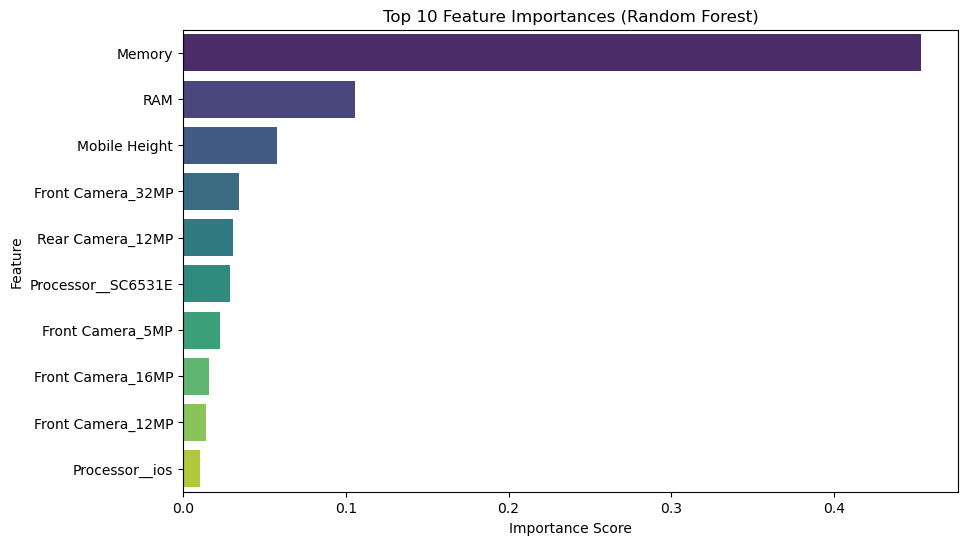


 Feature importances saved to 'Feature_Importances.xlsx'


In [72]:
# --- Preprocess data ---
df = df.fillna(df.median(numeric_only=True))
df = df.fillna(df.mode().iloc[0])
cat_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# --- Split into features and target ---
X = df.drop(columns=[target_col])
y = df[target_col]

# --- Train best model (Random Forest) ---
rf_model = RandomForestRegressor(random_state=42, n_estimators=200)
rf_model.fit(X, y)

# --- Get feature importances ---
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

# --- Display top 10 features ---
top_features = importances_sorted.head(10)
print("\n Top 10 Important Features Affecting Price:\n")
print(top_features)

# --- Visualize feature importance ---
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# --- Optional: Save importances to Excel ---
importances_sorted.to_excel("Feature_Importances.xlsx")
print("\n Feature importances saved to 'Feature_Importances.xlsx'")
